In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
unemploy = pd.read_csv("resources/UNRATE.csv", parse_dates = True, index_col="DATE")

In [34]:
unemploy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 867 entries, 1948-01-01 to 2020-03-01
Data columns (total 1 columns):
UNRATE    867 non-null float64
dtypes: float64(1)
memory usage: 13.5 KB


## Selection for testing and training
- Since out data is on a monthly base we will take 2 years of data to use as our testing set
- in this case 24 months

In [35]:
sample = 24 
sample_index = len(unemploy) - sample

In [36]:
sample_index

843

In [37]:
len(unemploy)

867

### Training and testing data 

In [38]:
train = unemploy.iloc[:sample_index]

In [39]:
test = unemploy.iloc[sample_index:]

In [40]:
train.shape

(843, 1)

In [41]:
test.shape

(24, 1)

## Scaling the data

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scalar = MinMaxScaler()

In [44]:
train_scaled = scalar.fit_transform(train)

In [45]:
test_scaled = scalar.transform(test)

### Generator Creation
- will use a length of 12 months for the batch generation for training

In [46]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
length = 12
generator  = TimeseriesGenerator(train_scaled,train_scaled, length= length, batch_size=1)

### Model creation
- Will add earling stopping to prevent overtraining

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)

In [51]:
n_features = 1

In [52]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length,n_features)))
model.add(Dense(units= 1))
model.compile(optimization = "adam", loss= "mse")

#### Model Summary

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Validaiton Generator
- Will need to capture our validaiton data in a validation generator to capture the loss value

In [54]:
vaid_gen = TimeseriesGenerator(test_scaled,test_scaled, length= length, batch_size=1)

### model fitting

In [55]:
model.fit_generator(generator = generator, validation_data=vaid_gen, epochs=13, callbacks= [stop])

Epoch 1/13
831/831 [==============================] - 270s 325ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 2/13
831/831 [==============================] - 301s 363ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 3/13
831/831 [==============================] - 288s 347ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/13
831/831 [==============================] - 327s 393ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/13
831/831 [==============================] - 310s 373ms/step - loss: 9.3406e-04 - val_loss: 0.0011
Epoch 6/13
831/831 [==============================] - 318s 383ms/step - loss: 8.8694e-04 - val_loss: 0.0011


## model evaluation
-model looks to have trained well

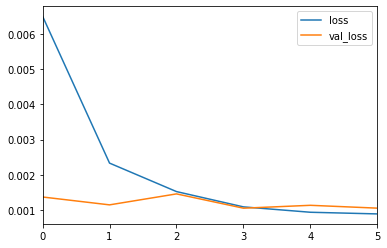

In [56]:
pd.DataFrame(model.history.history).plot()

## Predictons
-  Making Predicitons off the model

In [69]:
test_predictions = []
first_batch = train_scaled[-length:]
current_batch = first_batch.reshape((1,length, n_features))

for i in range(len(test)):
    current_predictions = model.predict(current_batch)[0]
    test_predictions.append(current_predictions)
    current_batch = np.append(current_batch[:,1:,:], [[current_predictions]], axis = 1)

In [70]:
test_predictions

[array([0.18857278], dtype=float32),
 array([0.1896534], dtype=float32),
 array([0.19198895], dtype=float32),
 array([0.19546159], dtype=float32),
 array([0.19966406], dtype=float32),
 array([0.20437515], dtype=float32),
 array([0.20985943], dtype=float32),
 array([0.21595597], dtype=float32),
 array([0.22233374], dtype=float32),
 array([0.22904792], dtype=float32),
 array([0.2359246], dtype=float32),
 array([0.242892], dtype=float32),
 array([0.2500612], dtype=float32),
 array([0.25717726], dtype=float32),
 array([0.26426142], dtype=float32),
 array([0.27116373], dtype=float32),
 array([0.27781427], dtype=float32),
 array([0.28417996], dtype=float32),
 array([0.29026517], dtype=float32),
 array([0.29598564], dtype=float32),
 array([0.30133918], dtype=float32),
 array([0.3063173], dtype=float32),
 array([0.31092775], dtype=float32),
 array([0.31517905], dtype=float32)]

## inverse scaling 
- remember we have trained on scaled data so we need to inverse this process

In [71]:
true_predictions = scalar.inverse_transform(test_predictions)

In [75]:
test

,UNRATE,predictions
DATE,,
2018-04-01,4.0,4.065154
2018-05-01,3.8,4.074123
2018-06-01,4.0,4.093508
2018-07-01,3.8,4.122331
2018-08-01,3.8,4.157212
2018-09-01,3.7,4.196314
2018-10-01,3.8,4.241833
2018-11-01,3.7,4.292435
2018-12-01,3.9,4.345370


In [72]:
true_predictions

array([[4.06515407],
       [4.07412319],
       [4.09350824],
       [4.12233116],
       [4.15721167],
       [4.19631373],
       [4.24183328],
       [4.29243457],
       [4.34537008],
       [4.40109777],
       [4.45817419],
       [4.51600358],
       [4.57550808],
       [4.63457129],
       [4.69336982],
       [4.75065897],
       [4.80585843],
       [4.85869363],
       [4.90920093],
       [4.9566808 ],
       [5.00111519],
       [5.04243359],
       [5.08070031],
       [5.11598611]])

In [73]:
test["predictions"] = true_predictions

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


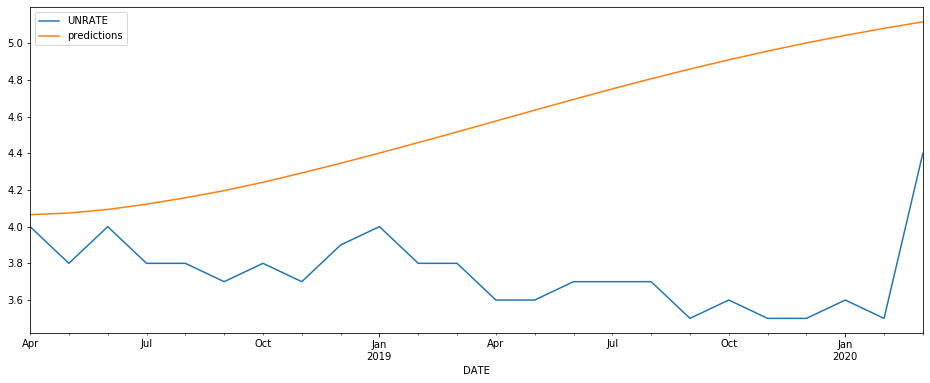

In [76]:
test.plot(figsize = (16,6))

## model predicctions are not too great ut lets see what our forcast will do since our one day outpredictions was pretty close

In [80]:
full_scalar = MinMaxScaler()

In [82]:
unemploy_scaled = full_scalar.fit_transform(unemploy)

In [83]:
genn = TimeseriesGenerator(unemploy_scaled,unemploy_scaled, length=length, batch_size=1)

In [84]:
model = Sequential()
model.add(LSTM(units = 100, activation= "relu", input_shape = (length, n_features)))
model.add(Dense(units=1))
model.compile(optimization = "adam", loss = "mse")

In [85]:
model.fit_generator(genn, epochs=20)

Epoch 1/20
855/855 [==============================] - 309s 362ms/step - loss: 0.0066
Epoch 2/20
855/855 [==============================] - 306s 358ms/step - loss: 0.0025
Epoch 3/20
855/855 [==============================] - 308s 360ms/step - loss: 0.0016
Epoch 4/20
855/855 [==============================] - 307s 360ms/step - loss: 0.0011
Epoch 5/20
855/855 [==============================] - 307s 359ms/step - loss: 9.8734e-04
Epoch 6/20
855/855 [==============================] - 309s 362ms/step - loss: 8.9275e-04
Epoch 7/20
855/855 [==============================] - 308s 361ms/step - loss: 8.4195e-04
Epoch 8/20
855/855 [==============================] - 312s 364ms/step - loss: 8.4334e-04
Epoch 9/20
855/855 [==============================] - 308s 360ms/step - loss: 8.1565e-04
Epoch 10/20
855/855 [==============================] - 308s 361ms/step - loss: 7.6761e-04
Epoch 11/20
855/855 [==============================] - 308s 360ms/step - loss: 7.4755e-04
Epoch 12/20
855/855 [==============

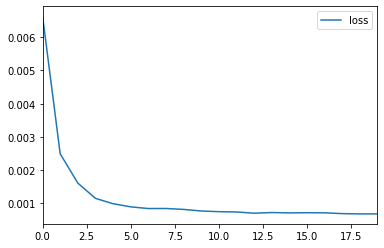

In [87]:
pd.DataFrame(model.history.history).plot()

## Forescating

In [88]:
forecast = []
period = length
first_batch = unemploy_scaled[-length:]
current_batch = first_batch.reshape((1,length,n_features))
for i in range(period):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [89]:
forecast

[array([0.22498947], dtype=float32),
 array([0.25041646], dtype=float32),
 array([0.278639], dtype=float32),
 array([0.3070843], dtype=float32),
 array([0.3358776], dtype=float32),
 array([0.36449835], dtype=float32),
 array([0.39223793], dtype=float32),
 array([0.41801935], dtype=float32),
 array([0.44236454], dtype=float32),
 array([0.46568862], dtype=float32),
 array([0.48855156], dtype=float32),
 array([0.51168805], dtype=float32)]

### 12 months in to the future 
- inverse scale the forecast 

In [90]:
true_forecast = full_scalar.inverse_transform(forecast)

In [91]:
true_forecast

array([[4.36741263],
       [4.5784566 ],
       [4.81270361],
       [5.04879963],
       [5.28778406],
       [5.52533628],
       [5.75557483],
       [5.96956064],
       [6.17162571],
       [6.36521551],
       [6.55497792],
       [6.74701084]])

## need Date time index for forecast data
- form the end of our original data set 

In [92]:
unemploy.tail()

,UNRATE
DATE,
2019-11-01,3.5
2019-12-01,3.5
2020-01-01,3.6
2020-02-01,3.5
2020-03-01,4.4


In [95]:
forcast_index = pd.date_range(start= "2020-04-01", periods=period, freq="MS")

## data frame with forecast data and indx

In [98]:
forecast_df = pd.DataFrame(true_forecast, index=forcast_index, columns=["forecast"])

In [99]:
forecast_df

,forecast
2020-04-01,4.367413
2020-05-01,4.578457
2020-06-01,4.812704
2020-07-01,5.048800
2020-08-01,5.287784
2020-09-01,5.525336
2020-10-01,5.755575
2020-11-01,5.969561
2020-12-01,6.171626
2021-01-01,6.365216


## Forecast Plot
- Model projects the Unemployment rate will climb for the next 12 months 
- Because the further our we go the more noose in our data, we will only consider 3 months but we may see asteady incrase in unemployment for the next few months during corona base on this model 

(453, 614)

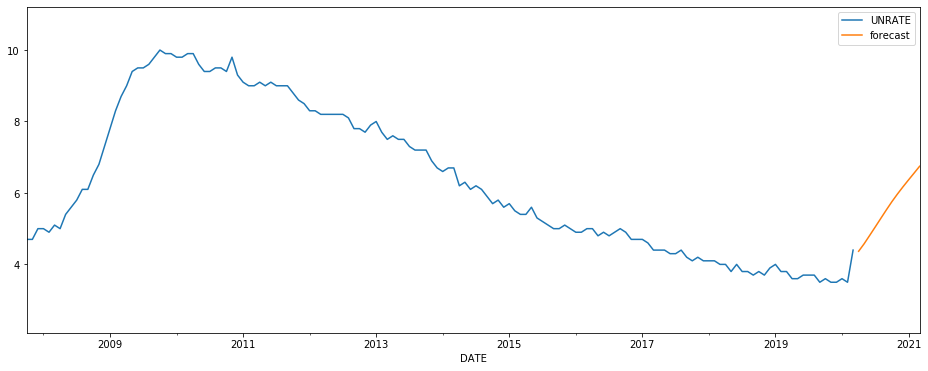

In [108]:
ax = unemploy.plot(figsize = (16,6))
forecast_df.plot(ax = ax)
plt.xlim("2007-10-1", "2021-03-01")